#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

def line():
    print('---------------------------------------')

In [3]:
data = pd.read_csv('/datasets/taxi.csv')
display(data)
line()
print(data.isnull().sum())
line()
print(len(data[data.duplicated()]))

data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
data = data.set_index('datetime').sort_index()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


---------------------------------------
datetime      0
num_orders    0
dtype: int64
---------------------------------------
0


Комментарий: Дубликаты отсутствуют, пустых значений нет

In [4]:
if(data.index.is_monotonic):
    print('Последовательность дат соблюдена')

display(data)
line()

data = data.resample('1H').sum()
display(data)

Последовательность дат соблюдена


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


---------------------------------------


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Комментарий: Ресемплинг выполнен, также выполнена проверка на хронологию последовательности дат

## Анализ

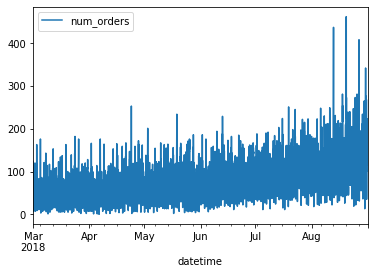

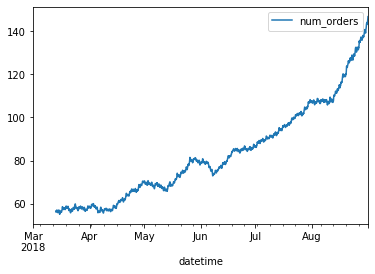

In [5]:
data.plot()
plt.show()

# Применим скользящее среднее

data.rolling(300).mean().plot()
plt.show()

Комментарий: После применения скользящего среднего мы видим, что количество поездок (заказов) такси ближе к летнему сезону увеличивается более чем в два раза, что логично и можно объснить тем, что это время отпусков, поездок в развлекательные центры, и т.д

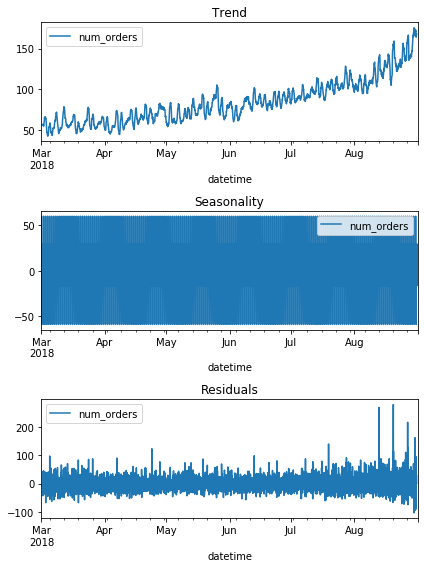

In [6]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Комментарий: Стрендом все понятно он также отображает то что среднее количество заказов увеличивается ближе к летнему сезону. Что касаемо сезонности, то если внимательно читать тренажер, то:

Сезонность (англ. seasonality) — циклично повторяющиеся закономерности во временном ряду. Допустим, рост продаж авиабилетов летом.
Тренды и сезонность зависят от масштаба данных. Нельзя увидеть закономерности, повторяющиеся каждое лето, если есть данные только за год.

Именно потому что у нас период только за год, мы не видим в сезонности закономерности

## Обучение

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    
    new_data = data.copy()
    
    new_data['year'] = data.index.year
    new_data['month'] = data.index.month
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    new_data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return new_data
    
data_for_split = make_features(data, 30, 30)

train_values, test_values = train_test_split(data_for_split, shuffle=False, test_size=0.1)
train_values = train_values.dropna()

target_train = train_values['num_orders']
features_train = train_values.drop('num_orders', axis=1)
target_test = test_values['num_orders']
features_test = test_values.drop('num_orders', axis=1)

In [8]:
models = (
    [LinearRegression(), 
     RandomForestRegressor(random_state = 12345, n_estimators=100, max_depth=100),
     DecisionTreeRegressor(random_state = 12345, max_depth=30)]  
)

for model in models:
    model.fit(features_train, target_train)
    pred_test = model.predict(features_test)
    pred_train = model.predict(features_train)

    print("RMSE обучающей выборки:", mean_squared_error(target_train, pred_train) ** 0.5)
    print("RMSE тестовой выборки: ", mean_squared_error(target_test, pred_test) ** 0.5)
    line()

RMSE обучающей выборки: 25.26179721820157
RMSE тестовой выборки:  46.88634057753085
---------------------------------------
RMSE обучающей выборки: 8.713112210426349
RMSE тестовой выборки:  43.3377971703069
---------------------------------------
RMSE обучающей выборки: 0.08337558090681194
RMSE тестовой выборки:  67.9704820149112
---------------------------------------


In [71]:
scores = []
list_results = []

tscv = TimeSeriesSplit(n_splits = 5)
best_result = 0
best_est = 0
best_depth = 0
previous_score = 0

for est in range(1, 300, 50):
    for depth in range(1, 300, 50):
        for train_index, valid_index in tscv.split(features_train):        
            model = RandomForestRegressor(random_state = 12345, n_estimators = est, max_depth = depth)
            model.fit(features_train.iloc[train_index], target_train.iloc[train_index])
            prediction = model.predict(features_train.iloc[valid_index])
            scores.append(mean_squared_error(target_train.iloc[valid_index], prediction) ** 0.5)
            
        list_results.append([sum(scores) / len(scores), est, depth])

In [72]:
display(pd.DataFrame(list_results))

,0,1,2
0,34.809739,1,1
1,35.825446,1,51
2,36.164015,1,101
3,36.333299,1,151
4,36.434870,1,201
5,36.502584,1,251
6,36.202271,51,1
7,34.912914,51,51
8,33.910082,51,101
9,33.107816,51,151


In [73]:
scores = []
list_results_test = []

tscv = TimeSeriesSplit(n_splits = 5)
best_result = 0
best_est = 0
best_depth = 0
previous_score = 0

for est in range(1, 300, 50):
    for depth in range(1, 300, 50):
        for train_index, valid_index in tscv.split(features_test):        
            model = RandomForestRegressor(random_state = 12345, n_estimators = est, max_depth = depth)
            model.fit(features_test.iloc[train_index], target_test.iloc[train_index])
            prediction = model.predict(features_test.iloc[valid_index])
            scores.append(mean_squared_error(target_test.iloc[valid_index], prediction) ** 0.5)
            
        list_results_test.append([sum(scores) / len(scores), est, depth])

In [74]:
display(pd.DataFrame(list_results_test))

,0,1,2
0,52.717686,1,1
1,54.832922,1,51
2,55.538000,1,101
3,55.890540,1,151
4,56.102063,1,201
5,56.243079,1,251
6,55.434890,51,1
7,54.072672,51,51
8,53.013170,51,101
9,52.165568,51,151


In [11]:
model = RandomForestRegressor(random_state = 12345, n_estimators = 251, max_depth = 251)
model.fit(features_train, target_train)
prediction = model.predict(features_test)

print('RMSE на тесте: ', mean_squared_error(target_test, prediction) ** 0.5)

RMSE на тесте:  43.34360001607408


Комментарий: При изменнении значений гиперпараметров в моделях результат останавливается и больше не улучшается. Лучшими показателями RMSE обладает модель линейной регрессии